# Import danych

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('cyberbullying_tweets.csv')

In [3]:
data.head(10)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [4]:
data['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


# Wstępne oczyszczanie danych

In [6]:
data = data.rename(columns = {'tweet_text':'text'})

In [7]:
data.duplicated().sum()

36

In [8]:
data = data[~data.duplicated()]

In [9]:
data.duplicated().sum()

0

In [10]:
data.head()

,text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                47656 non-null  object
 1   cyberbullying_type  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [12]:
data.cyberbullying_type.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

# Wstępne przetwarzanie danych

In [13]:
import re, string
import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

seed_value=8
random.seed(seed_value)
np.random.seed(seed_value)

In [14]:
# to remove stop words which will not be analyzed during classification
stop_words = set(stopwords.words('english'))

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def remove_emoji(text):
    return demoji.replace(text, '')

In [17]:
def remove_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non ASCII characters
    text = re.sub(r'[^\w]', ' ', text) # remove non alphanumeric symbol  
    text = re.sub(r'\s+', ' ', str(text)) #remove whitespaces
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split())
    return text

In [18]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [19]:
def remove_hashtags(tweet):
    new = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new2 = " ".join(word.strip() for word in re.split('#|_', new)) #remove hashtags symbol from words in the middle of the sentence
    return new2

In [20]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

In [21]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

In [22]:
def deep_clean(text):
    text = remove_emoji(text)
    text = decontract(text)
    text = remove_entities(text)
    text = remove_hashtags(text)
    #text = filter_chars(text)
    #text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [23]:
data_new = []
for text in data.text:
    data_new.append(deep_clean(text))

In [24]:
data['cleaned_text'] = data_new

In [25]:
text_len = []
for text in data.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
data['text_len'] = text_len

In [26]:
data.head()

,text,cyberbullying_type,cleaned_text,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8


In [27]:
data.cleaned_text.duplicated().sum()

2968

In [28]:
data.drop_duplicates('cleaned_text', inplace=True)

In [29]:
# sprawdzenie liczności każdej z klas
data.cyberbullying_type.value_counts()

religion               7954
age                    7884
ethnicity              7776
not_cyberbullying      7658
gender                 7619
other_cyberbullying    5797
Name: cyberbullying_type, dtype: int64

In [30]:
# usunięcie klasy o mniejszej liczności niż pozostałe
data = data[data['cyberbullying_type'] != 'other_cyberbullying']

In [31]:
data.cyberbullying_type.value_counts()

religion             7954
age                  7884
ethnicity            7776
not_cyberbullying    7658
gender               7619
Name: cyberbullying_type, dtype: int64

In [32]:
data.head()

,text,cyberbullying_type,cleaned_text,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8


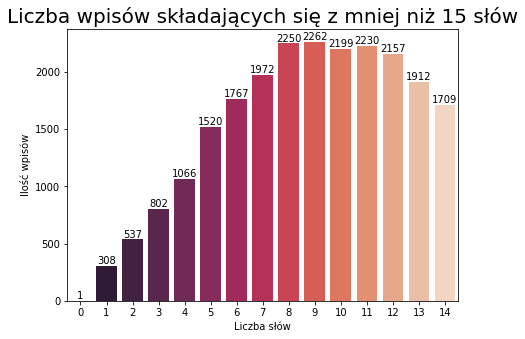

In [33]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<15], palette='rocket')
plt.title('Liczba wpisów składających się z mniej niż 15 słów', fontsize=20)
plt.ylabel('Ilość wpisów')
plt.xlabel('Liczba słów')
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [34]:
# usunięcie tweetów z mniej niż 3 słowami
data = data[data['text_len'] > 2]

In [35]:
x = data['text_len'].unique().sort()

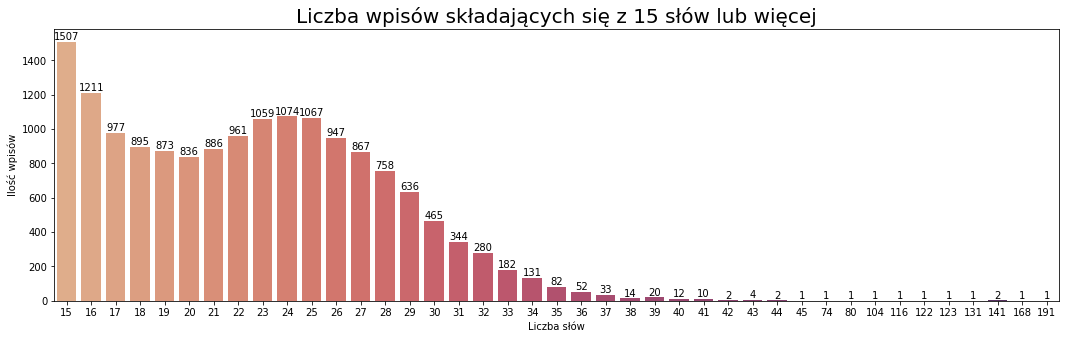

In [36]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']>14], palette='flare')
plt.title('Liczba wpisów składających się z 15 słów lub więcej', fontsize=20)
plt.ylabel('Ilość wpisów')
plt.xlabel('Liczba słów')
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [37]:
# usunięcie tweetów z więcej niż 50 słowami
data = data[data['text_len'] < 50]

Zamiana kategorii na wartości liczbowe.

In [38]:
encoding_classes = {'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4}
data['class'] = data['cyberbullying_type'].replace(encoding_classes)

In [39]:
data.sort_values('text_len', ascending=False)

,text,cyberbullying_type,cleaned_text,text_len,class
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45,2
21040,QUESTIONS 1)4x4-BONES 2)Black And Blue-Crystal...,religion,question 1 4x4 bone 2 black blue crystal lake ...,44,0
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,44,0
42863,THIS IS WHY I SANK THE BITCH ASS KRAKAS...SAME...,ethnicity,sank bitch ass kraka shit fuka even know build...,43,2
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43,2
...,...,...,...,...,...
4222,"Oh man, yes! https://t.co/OspX66okpB",not_cyberbullying,oh man ye,3,4
4214,Manu just shut her up 😂🙌🙌 #mkr,not_cyberbullying,manu shut mkr,3,4
4209,This class is going by SO SLOW. 🕡🕟🕠🕞🕥🕗🕛,not_cyberbullying,class go slow,3,4
4198,I just want everyone to be happy!,not_cyberbullying,want everyon happi,3,4


In [40]:
data.cyberbullying_type.value_counts()

religion             7944
age                  7869
ethnicity            7761
gender               7470
not_cyberbullying    6990
Name: cyberbullying_type, dtype: int64

In [41]:
classes = ['religion', 'age', 'ethnicity', 'gender', 'not_cyberbullying']

# Tworzenie wektorów z danymi

In [42]:
def stemming(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return [ps.stem(words) for words in tokenized]

In [43]:
data_new2 = []
for text in data.cleaned_text:
    data_new2.append(stemming(text))

In [44]:
data['svm_text'] = data_new2

In [45]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [46]:
data.head()

,text,cyberbullying_type,cleaned_text,text_len,class,svm_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5,4,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11,4,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5,4,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9,4,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8,4,"[isi, account, pretend, kurdish, account, like..."


# Podział na zbiór testowy i treningowy

In [47]:
X = data['cleaned_text']
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed_value)

In [48]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6355],
       [   1, 6295],
       [   2, 6209],
       [   3, 5976],
       [   4, 5592]])

Ponieważ klasy nie są równoliczne, generujemy dodatkowe próbki.

In [49]:
#ros = RandomOverSampler()
#X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
#train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['cleaned_text', 'class']);

In [50]:
#X_train = train_os['cleaned_text'].values
#y_train = train_os['class'].values

In [51]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6355],
       [   1, 6295],
       [   2, 6209],
       [   3, 5976],
       [   4, 5592]])

# Najczęściej występujące słowa dla każdej z klas

In [52]:
data[(data.cyberbullying_type == 'religion')][['svm_text']].apply(count_words)['svm_text'].most_common(10)

[('muslim', 4837),
 ('idiot', 3132),
 ('islam', 2508),
 ('christian', 2201),
 ('u', 1585),
 ('terrorist', 1450),
 ('right', 1334),
 ('like', 1283),
 ('support', 1263),
 ('terror', 1252)]

In [53]:
data[(data.cyberbullying_type == 'age')][['svm_text']].apply(count_words)['svm_text'].most_common(10)

[('bulli', 8983),
 ('school', 8527),
 ('high', 4999),
 ('girl', 4646),
 ('like', 2084),
 ('get', 1053),
 ('one', 1050),
 ('peopl', 934),
 ('got', 841),
 ('kid', 817)]

In [54]:
data[(data.cyberbullying_type == 'gender')][['svm_text']].apply(count_words)['svm_text'].most_common(10)

[('joke', 5232),
 ('rape', 4235),
 ('gay', 4012),
 ('call', 1402),
 ('make', 1289),
 ('rt', 1215),
 ('bitch', 1151),
 ('femal', 1127),
 ('peopl', 998),
 ('like', 985)]

In [55]:
data[(data.cyberbullying_type == 'ethnicity')][['svm_text']].apply(count_words)['svm_text'].most_common(10)

[('fuck', 5934),
 ('nigger', 5578),
 ('dumb', 5035),
 ('ass', 2252),
 ('black', 2169),
 ('u', 1842),
 ('white', 1582),
 ('call', 1385),
 ('rt', 1193),
 ('peopl', 1180)]

In [56]:
data[(data.cyberbullying_type == 'not_cyberbullying')][['svm_text']].apply(count_words)['svm_text'].most_common(10)

[('mkr', 1557),
 ('bulli', 1138),
 ('rt', 773),
 ('get', 422),
 ('like', 416),
 ('go', 382),
 ('school', 368),
 ('kat', 295),
 ('would', 285),
 ('amp', 281)]

# Naive Bayes

In [57]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [58]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [59]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [60]:
nb_pred = nb_clf.predict(X_test_tf)

In [74]:
print('Results for Naive Bayes:\n',
      classification_report(y_test, nb_pred, target_names=classes))

Results for Naive Bayes:
                    precision    recall  f1-score   support

         religion       0.83      0.97      0.89      1589
              age       0.77      0.98      0.86      1574
        ethnicity       0.89      0.92      0.90      1552
           gender       0.89      0.85      0.87      1494
not_cyberbullying       0.85      0.43      0.57      1398

         accuracy                           0.84      7607
        macro avg       0.84      0.83      0.82      7607
     weighted avg       0.84      0.84      0.82      7607



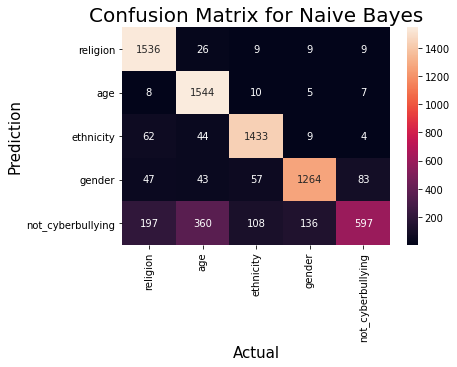

In [72]:
conf_matrix = confusion_matrix(y_test, nb_pred)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes,
    )
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Actual',fontsize=15)
plt.title('Confusion Matrix for Naive Bayes',fontsize=20)
plt.show()

# SVM

In [63]:
from sklearn.svm import LinearSVC

In [64]:
lsvc = LinearSVC(multi_class='ovr')
lsvc.fit(X_train_tf, y_train)

LinearSVC()

In [65]:
svm_pred = lsvc.predict(X_test_tf)

In [66]:
print('Results for SVM:\n',
      classification_report(y_test, svm_pred, target_names=classes))

Results for SVM:
                    precision    recall  f1-score   support

         religion       0.96      0.95      0.96      1589
              age       0.94      0.98      0.96      1574
        ethnicity       0.98      0.99      0.98      1552
           gender       0.93      0.89      0.91      1494
not_cyberbullying       0.82      0.82      0.82      1398

         accuracy                           0.93      7607
        macro avg       0.93      0.93      0.93      7607
     weighted avg       0.93      0.93      0.93      7607



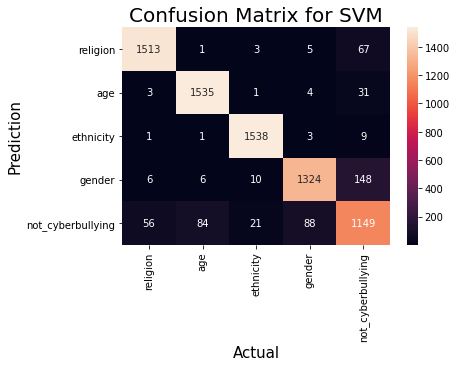

In [73]:
conf_matrix = confusion_matrix(y_test, svm_pred)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes,
    )
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Actual',fontsize=15)
plt.title('Confusion Matrix for SVM',fontsize=20)
plt.show()

In [68]:
#clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
#clf_output = clf.fit(X_train_tf, y_train)

In [69]:
#clf_pred = clf.predict(X_test_tf)

In [70]:
#print('Classification Report for SVM:\n',
  #    classification_report(y_test, clf_pred, target_names=classes))

In [71]:
#conf_matrix = confusion_matrix(y_test, clf_pred)
#sns.heatmap(conf_matrix,
#            annot=True,
#            fmt='g',
#            xticklabels=classes,
#            yticklabels=classes,
#    )
#plt.ylabel('Prediction',fontsize=15)
#plt.xlabel('Actual',fontsize=15)
#plt.title('Confusion Matrix',fontsize=20)
#plt.show()